# Retrain Models with Reduced Features (PCA)

This notebook retrains LSTM and other models using the PCA-reduced feature set (57 components instead of 175).

**Feature Selection Results:**
- Original features: 175 (16 statistical + 159 EMD)
- After redundancy removal: 145 features
- PCA (95% variance): 57 components
- Best strategy: PCA (95% variance) - Test MAE: 20.110 cycles, R²: 0.157

**Goals:**
1. Load PCA transformers and feature selection info
2. Apply PCA transformation to features
3. Retrain LSTM with 57-component features
4. Retrain Random Forest with reduced features
5. Compare performance: original vs reduced features


In [ ]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import joblib
import json
import time
import warnings
warnings.filterwarnings('ignore')

# PyTorch for LSTM
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Bayesian Optimization for LSTM hyperparameter tuning
import optuna

# Add project root to path
project_root = Path("/Users/siddhantaggarwal/Desktop/Battery_RUL").resolve()
sys.path.append(str(project_root))

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Set device
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✅ Using MPS (Apple Silicon GPU acceleration)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("✅ Using CUDA (NVIDIA GPU)")
else:
    device = torch.device("cpu")
    print("⚠️ Using CPU")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")
print("✅ Imports complete!")


✅ Using MPS (Apple Silicon GPU acceleration)
PyTorch version: 2.9.0
Device: mps
✅ Imports complete!


## Step 1: Load Feature Selection Info and Transformers


In [2]:
# Load feature selection info
models_dir = project_root / "results" / "models"
with open(models_dir / "feature_selection_info.json", 'r') as f:
    feature_selection_info = json.load(f)

print("📊 Feature Selection Info:")
print(f"  Method: {feature_selection_info['method']}")
print(f"  Strategy: {feature_selection_info['strategy']}")

if feature_selection_info['method'] == 'pca':
    n_components = feature_selection_info['n_components']
    features_after_redundancy = feature_selection_info['features_after_redundancy_removal']
    
    # Load PCA and scaler
    pca = joblib.load(models_dir / "feature_selection_pca.pkl")
    scaler_pca = joblib.load(models_dir / "feature_selection_scaler.pkl")
    
    print(f"  PCA Components: {n_components}")
    print(f"  Features after redundancy removal: {len(features_after_redundancy)}")
    print(f"  ✅ PCA transformers loaded!")
else:
    print(f"  ⚠️ Feature selection method '{feature_selection_info['method']}' not yet supported")
    print(f"  Please use PCA method for now")


📊 Feature Selection Info:
  Method: pca
  Strategy: PCA (95% variance)
  PCA Components: 57
  Features after redundancy removal: 145
  ✅ PCA transformers loaded!


## Step 2: Load Data and Apply PCA Transformation


In [3]:
# Load dataset
processed_dir = project_root / "data" / "processed"
df = pd.read_parquet(processed_dir / "rul_features_with_emd.parquet")

print(f"Dataset shape: {df.shape}")

# Filter out rows with NaN RUL
df_clean = df[df['RUL'].notna()].copy()
print(f"After removing NaN RUL: {len(df_clean)} rows")

# Prepare features (use features after redundancy removal)
exclude_cols = [
    'battery_id', 'filename', 'type', 'start_time', 'test_id', 'uid',
    'split', 'cycle_index', 'EOL_cycle', 'RUL', 'SOH', 'Capacity', 
    'Re', 'Rct', 'ambient_temperature'
]

# Use features after redundancy removal
feature_cols_reduced = features_after_redundancy
print(f"\nFeatures after redundancy removal: {len(feature_cols_reduced)}")

# Split by battery
train_idx = df_clean['split'] == 'train'
test_idx = df_clean['split'] == 'test'

df_train = df_clean[train_idx].copy()
df_test = df_clean[test_idx].copy()

# Extract features and apply PCA transformation
X_train_raw = df_train[feature_cols_reduced].fillna(0).values
X_test_raw = df_test[feature_cols_reduced].fillna(0).values

# Standardize and apply PCA
X_train_scaled = scaler_pca.transform(X_train_raw)
X_test_scaled = scaler_pca.transform(X_test_raw)

X_train_pca = pca.transform(X_train_scaled)[:, :n_components]
X_test_pca = pca.transform(X_test_scaled)[:, :n_components]

print(f"\n✅ PCA transformation applied!")
print(f"  Original features: {len(feature_cols_reduced)}")
print(f"  PCA components: {n_components}")
print(f"  Train shape: {X_train_pca.shape}")
print(f"  Test shape: {X_test_pca.shape}")

# Get targets
y_train = df_train['RUL'].values
y_test = df_test['RUL'].values


Dataset shape: (2750, 190)
After removing NaN RUL: 1408 rows

Features after redundancy removal: 145

✅ PCA transformation applied!
  Original features: 145
  PCA components: 57
  Train shape: (1158, 57)
  Test shape: (250, 57)


## Step 3: Retrain Random Forest with Reduced Features


In [ ]:
# Train Random Forest with PCA features using GridSearchCV for hyperparameter optimization
print("Training Random Forest with PCA-reduced features...")
print("Performing GridSearchCV to find best hyperparameters...")

# Define parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 15, 20, 25, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Base Random Forest model
rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

# Perform GridSearchCV with cross-validation
print("Starting GridSearchCV (this may take a few minutes)...")
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_absolute_error',  # Use MAE as scoring metric
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_pca, y_train)

# Get best model
rf_reduced = grid_search.best_estimator_

print(f"\n✅ GridSearchCV completed!")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score (MAE): {-grid_search.best_score_:.2f} cycles")

# Predictions
y_train_pred_rf = rf_reduced.predict(X_train_pca)
y_test_pred_rf = rf_reduced.predict(X_test_pca)

# Metrics
train_mae_rf = mean_absolute_error(y_train, y_train_pred_rf)
train_rmse_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
train_r2_rf = r2_score(y_train, y_train_pred_rf)

test_mae_rf = mean_absolute_error(y_test, y_test_pred_rf)
test_rmse_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
test_r2_rf = r2_score(y_test, y_test_pred_rf)

print("\n✅ Random Forest trained with optimized hyperparameters!")
print(f"\nTrain Metrics:")
print(f"  MAE: {train_mae_rf:.2f} cycles")
print(f"  RMSE: {train_rmse_rf:.2f} cycles")
print(f"  R²: {train_r2_rf:.3f}")

print(f"\nTest Metrics:")
print(f"  MAE: {test_mae_rf:.2f} cycles")
print(f"  RMSE: {test_rmse_rf:.2f} cycles")
print(f"  R²: {test_r2_rf:.3f}")

# Save model and best parameters
joblib.dump(rf_reduced, models_dir / "random_forest_rul_point_model_reduced.pkl")
joblib.dump(grid_search.best_params_, models_dir / "random_forest_reduced_best_params.pkl")
print(f"\n✅ Saved model and best parameters to {models_dir}")


Training Random Forest with PCA-reduced features...

✅ Random Forest trained!

Train Metrics:
  MAE: 7.61 cycles
  RMSE: 10.00 cycles
  R²: 0.949

Test Metrics:
  MAE: 20.08 cycles
  RMSE: 24.89 cycles
  R²: 0.160

✅ Saved model to /Users/siddhantaggarwal/Desktop/Battery_RUL/results/models/random_forest_rul_point_model_reduced.pkl


## Step 4: Retrain LSTM with Reduced Features


In [5]:
# Create sequences for LSTM with PCA features
sequence_length = 20

def create_sequences_pca(df_subset, pca_features, target_col, seq_len=sequence_length):
    """Create sequences for LSTM training with PCA features."""
    sequences = []
    targets = []
    
    # Group by battery_id
    for battery_id in df_subset['battery_id'].unique():
        battery_mask = df_subset['battery_id'] == battery_id
        battery_indices = df_subset[battery_mask].sort_values('cycle_index').index
        
        # Get PCA features and targets for this battery
        battery_pca = pca_features[battery_mask][np.argsort(df_subset[battery_mask]['cycle_index'])]
        battery_target = df_subset.loc[battery_indices, target_col].values.astype(np.float32)
        
        if len(battery_pca) >= seq_len:
            n_seqs = len(battery_pca) - seq_len
            for i in range(n_seqs):
                sequences.append(battery_pca[i:i+seq_len])
                targets.append(battery_target[i+seq_len])
    
    return np.array(sequences, dtype=np.float32), np.array(targets, dtype=np.float32)

print(f"Creating sequences with length {sequence_length}...")
X_train_seq, y_train_seq = create_sequences_pca(df_train, X_train_pca, 'RUL', sequence_length)
X_test_seq, y_test_seq = create_sequences_pca(df_test, X_test_pca, 'RUL', sequence_length)

print(f"Train sequences: {X_train_seq.shape}")
print(f"Test sequences: {X_test_seq.shape}")
print(f"Feature shape per timestep: {X_train_seq.shape[2]} (reduced from 175)")


Creating sequences with length 20...
Train sequences: (918, 20, 57)
Test sequences: (190, 20, 57)
Feature shape per timestep: 57 (reduced from 175)


In [6]:
# Define LSTM model (same architecture as original, but with reduced input size)
class LSTMModel(nn.Module):
    """LSTM model architecture."""
    def __init__(self, input_size, hidden_size1=64, hidden_size2=32, num_layers=1, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size1, num_layers, 
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.lstm2 = nn.LSTM(hidden_size1, hidden_size2, num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc1 = nn.Linear(hidden_size2, 16)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(16, 1)
    
    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out = out[:, -1, :]
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out.squeeze()

# Dataset class
class BatteryDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = torch.FloatTensor(sequences)
        self.targets = torch.FloatTensor(targets)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

# Create model with reduced input size
input_size = n_components  # 57 instead of 175
model = LSTMModel(input_size=input_size, hidden_size1=64, hidden_size2=32, dropout=0.2).to(device)

print(f"✅ Model created with input size: {input_size}")
print(f"   Total parameters: {sum(p.numel() for p in model.parameters()):,}")


✅ Model created with input size: 57
   Total parameters: 44,577


In [7]:
# Normalize features for LSTM (StandardScaler on sequences)
# Reshape sequences to (n_samples * seq_len, n_features) for scaling
n_train, seq_len, n_feat = X_train_seq.shape
n_test = X_test_seq.shape[0]

X_train_flat = X_train_seq.reshape(-1, n_feat)
X_test_flat = X_test_seq.reshape(-1, n_feat)

scaler_lstm = StandardScaler()
X_train_scaled_flat = scaler_lstm.fit_transform(X_train_flat)
X_test_scaled_flat = scaler_lstm.transform(X_test_flat)

# Reshape back
X_train_seq_scaled = X_train_scaled_flat.reshape(n_train, seq_len, n_feat)
X_test_seq_scaled = X_test_scaled_flat.reshape(n_test, seq_len, n_feat)

print("✅ Features normalized for LSTM")

# Create datasets and loaders
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
    X_train_seq_scaled, y_train_seq, test_size=0.2, random_state=42
)

train_dataset = BatteryDataset(X_train_final, y_train_final)
val_dataset = BatteryDataset(X_val_final, y_val_final)
test_dataset = BatteryDataset(X_test_seq_scaled, y_test_seq)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Training on {len(train_dataset)} samples, validating on {len(val_dataset)} samples")


✅ Features normalized for LSTM
Training on 734 samples, validating on 184 samples


In [ ]:
# Bayesian Optimization with Optuna for LSTM hyperparameter tuning
print("Starting Bayesian Optimization with Optuna to find best hyperparameters...")

def objective(trial):
    """Objective function for Optuna optimization."""
    # Suggest hyperparameters
    hidden_size1 = trial.suggest_int('hidden_size1', 32, 128, step=16)
    hidden_size2 = trial.suggest_int('hidden_size2', 16, 64, step=8)
    dropout = trial.suggest_float('dropout', 0.1, 0.5, step=0.1)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    num_epochs = trial.suggest_int('num_epochs', 30, 80, step=10)
    
    # Create model with suggested hyperparameters
    model_trial = LSTMModel(
        input_size=input_size,
        hidden_size1=hidden_size1,
        hidden_size2=hidden_size2,
        dropout=dropout
    ).to(device)
    
    # Training setup
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model_trial.parameters(), lr=learning_rate)
    
    # Create data loaders with suggested batch size
    train_loader_trial = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader_trial = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    # Training loop with early stopping
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        # Training phase
        model_trial.train()
        train_loss = 0.0
        
        for batch_X, batch_y in train_loader_trial:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model_trial(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation phase
        model_trial.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader_trial:
                batch_X = batch_X.to(device)
                batch_y = batch_y.to(device)
                
                outputs = model_trial(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
        
        val_loss /= len(val_loader_trial)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            break
        
        # Report intermediate value for pruning
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    return best_val_loss

# Create Optuna study
study = optuna.create_study(
    direction='minimize',
    study_name='lstm_hyperparameter_optimization',
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=10)
)

print("Running Optuna optimization (this may take a while)...")
study.optimize(objective, n_trials=20, show_progress_bar=True)

print(f"\n✅ Optuna optimization completed!")
print(f"Best trial:")
print(f"  Value (validation loss): {study.best_value:.4f}")
print(f"  Params:")
for key, value in study.best_params.items():
    print(f"    {key}: {value}")

# Train final model with best hyperparameters
best_params = study.best_params
print(f"\nTraining final model with best hyperparameters...")

# Create final model with best hyperparameters
model = LSTMModel(
    input_size=input_size,
    hidden_size1=best_params['hidden_size1'],
    hidden_size2=best_params['hidden_size2'],
    dropout=best_params['dropout']
).to(device)

# Training setup with best hyperparameters
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])

# Create data loaders with best batch size
batch_size = best_params['batch_size']
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Training loop
num_epochs = best_params['num_epochs']
patience = 10
best_val_loss = float('inf')
patience_counter = 0

train_losses = []
val_losses = []

print("Starting final training...")
start_time = time.time()

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), models_dir / "lstm_pytorch_reduced_best_model.pth")
    else:
        patience_counter += 1
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# Load best model
model.load_state_dict(torch.load(models_dir / "lstm_pytorch_reduced_best_model.pth"))
print("✅ Loaded best model weights")

elapsed_time = time.time() - start_time
print(f"Training completed in {elapsed_time:.1f} seconds")


Starting training...
Epoch 10/50: Train Loss: 628.8212, Val Loss: 622.2708
Epoch 20/50: Train Loss: 163.4858, Val Loss: 165.3811
Epoch 30/50: Train Loss: 105.1973, Val Loss: 68.6324
Epoch 40/50: Train Loss: 76.0852, Val Loss: 28.6537
Epoch 50/50: Train Loss: 70.3124, Val Loss: 17.4374
✅ Loaded best model weights
Training completed in 6.6 seconds


In [ ]:
# Evaluate LSTM model
model.eval()
train_preds = []
test_preds = []

with torch.no_grad():
    for batch_X, _ in DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0):
        batch_X = batch_X.to(device)
        preds = model(batch_X)
        train_preds.extend(preds.cpu().numpy())
    
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        preds = model(batch_X)
        test_preds.extend(preds.cpu().numpy())

train_preds = np.array(train_preds)
test_preds = np.array(test_preds)

# Metrics
train_mae_lstm = mean_absolute_error(y_train_final, train_preds)
train_rmse_lstm = np.sqrt(mean_squared_error(y_train_final, train_preds))
train_r2_lstm = r2_score(y_train_final, train_preds)

test_mae_lstm = mean_absolute_error(y_test_seq, test_preds)
test_rmse_lstm = np.sqrt(mean_squared_error(y_test_seq, test_preds))
test_r2_lstm = r2_score(y_test_seq, test_preds)

print("\n✅ LSTM Evaluation Complete!")
print(f"\nTrain Metrics:")
print(f"  MAE: {train_mae_lstm:.2f} cycles")
print(f"  RMSE: {train_rmse_lstm:.2f} cycles")
print(f"  R²: {train_r2_lstm:.3f}")

print(f"\nTest Metrics:")
print(f"  MAE: {test_mae_lstm:.2f} cycles")
print(f"  RMSE: {test_rmse_lstm:.2f} cycles")
print(f"  R²: {test_r2_lstm:.3f}")

# Save model and scaler
torch.save(model.state_dict(), models_dir / "lstm_pytorch_reduced_point_model.pth")
joblib.dump(scaler_lstm, models_dir / "lstm_pytorch_reduced_scaler.pkl")

# Save model info with best hyperparameters
model_info = {
    'input_size': n_components,
    'hidden_size1': best_params['hidden_size1'],
    'hidden_size2': best_params['hidden_size2'],
    'num_layers': 1,
    'dropout': best_params['dropout'],
    'learning_rate': best_params['learning_rate'],
    'batch_size': best_params['batch_size'],
    'sequence_length': sequence_length,
    'feature_selection_method': 'pca',
    'n_components': n_components,
    'optimization_method': 'optuna_bayesian',
    'best_validation_loss': study.best_value
}

with open(models_dir / "lstm_pytorch_reduced_model_info.json", 'w') as f:
    json.dump(model_info, f, indent=2)

print(f"\n✅ Saved model and info to {models_dir}")



✅ LSTM Evaluation Complete!

Train Metrics:
  MAE: 2.31 cycles
  RMSE: 3.70 cycles
  R²: 0.992

Test Metrics:
  MAE: 15.54 cycles
  RMSE: 20.51 cycles
  R²: 0.145

✅ Saved model and info to /Users/siddhantaggarwal/Desktop/Battery_RUL/results/models


## Step 5: Compare Performance (Original vs Reduced Features)


In [10]:
# Load original model metrics for comparison
try:
    # Try to load original LSTM metrics
    original_lstm_info_path = models_dir / "lstm_pytorch_model_info.json"
    if original_lstm_info_path.exists():
        # Original LSTM metrics (from previous training)
        original_lstm_test_mae = 16.74
        original_lstm_test_rmse = 20.35
        original_lstm_test_r2 = 0.159
        
        # Original RF metrics
        original_rf_test_mae = 21.28
        original_rf_test_rmse = 27.89
        original_rf_test_r2 = -0.055
        
        print("📊 Performance Comparison: Original vs Reduced Features\n")
        print("="*80)
        
        # LSTM Comparison
        print("\n🔵 LSTM Model:")
        print(f"{'Metric':<15} {'Original (175)':<20} {'Reduced (57)':<20} {'Change':<15}")
        print("-"*70)
        print(f"{'Test MAE':<15} {original_lstm_test_mae:<20.2f} {test_mae_lstm:<20.2f} {test_mae_lstm - original_lstm_test_mae:+.2f}")
        print(f"{'Test RMSE':<15} {original_lstm_test_rmse:<20.2f} {test_rmse_lstm:<20.2f} {test_rmse_lstm - original_lstm_test_rmse:+.2f}")
        print(f"{'Test R²':<15} {original_lstm_test_r2:<20.3f} {test_r2_lstm:<20.3f} {test_r2_lstm - original_lstm_test_r2:+.3f}")
        
        # RF Comparison
        print("\n🟢 Random Forest Model:")
        print(f"{'Metric':<15} {'Original (175)':<20} {'Reduced (57)':<20} {'Change':<15}")
        print("-"*70)
        print(f"{'Test MAE':<15} {original_rf_test_mae:<20.2f} {test_mae_rf:<20.2f} {test_mae_rf - original_rf_test_mae:+.2f}")
        print(f"{'Test RMSE':<15} {original_rf_test_rmse:<20.2f} {test_rmse_rf:<20.2f} {test_rmse_rf - original_rf_test_rmse:+.2f}")
        print(f"{'Test R²':<15} {original_rf_test_r2:<20.3f} {test_r2_rf:<20.3f} {test_r2_rf - original_rf_test_r2:+.3f}")
        
        print("\n" + "="*80)
        
        # Determine if reduced features improved performance
        lstm_improved = test_mae_lstm < original_lstm_test_mae
        rf_improved = test_mae_rf < original_rf_test_mae
        
        print(f"\n✅ LSTM: {'IMPROVED' if lstm_improved else 'WORSE'} (MAE: {test_mae_lstm:.2f} vs {original_lstm_test_mae:.2f})")
        print(f"✅ Random Forest: {'IMPROVED' if rf_improved else 'WORSE'} (MAE: {test_mae_rf:.2f} vs {original_rf_test_mae:.2f})")
        
        # Check overfitting reduction
        # For original: Train R² = 0.756, Test R² = 0.159
        # For reduced: Use train R² from training split, Test R² from test set
        lstm_overfit_original = 0.756 - 0.159  # Train R² - Test R² (from original)
        lstm_overfit_reduced = train_r2_lstm - test_r2_lstm
        
        print(f"\n📉 Overfitting Analysis (LSTM):")
        print(f"  Original: Train R² - Test R² = {lstm_overfit_original:.3f}")
        print(f"  Reduced: Train R² - Test R² = {lstm_overfit_reduced:.3f}")
        print(f"  Overfitting {'REDUCED' if lstm_overfit_reduced < lstm_overfit_original else 'INCREASED'}")
        
except Exception as e:
    print(f"⚠️ Could not load original metrics: {e}")
    print("Showing only reduced feature results above.")


📊 Performance Comparison: Original vs Reduced Features


🔵 LSTM Model:
Metric          Original (175)       Reduced (57)         Change         
----------------------------------------------------------------------
Test MAE        16.74                15.54                -1.20
Test RMSE       20.35                20.51                +0.16
Test R²         0.159                0.145                -0.014

🟢 Random Forest Model:
Metric          Original (175)       Reduced (57)         Change         
----------------------------------------------------------------------
Test MAE        21.28                20.08                -1.20
Test RMSE       27.89                24.89                -3.00
Test R²         -0.055               0.160                +0.215


✅ LSTM: IMPROVED (MAE: 15.54 vs 16.74)
✅ Random Forest: IMPROVED (MAE: 20.08 vs 21.28)

📉 Overfitting Analysis (LSTM):
  Original: Train R² - Test R² = 0.597
  Reduced: Train R² - Test R² = 0.846
  Overfitting INCREASED


ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of labels (2).

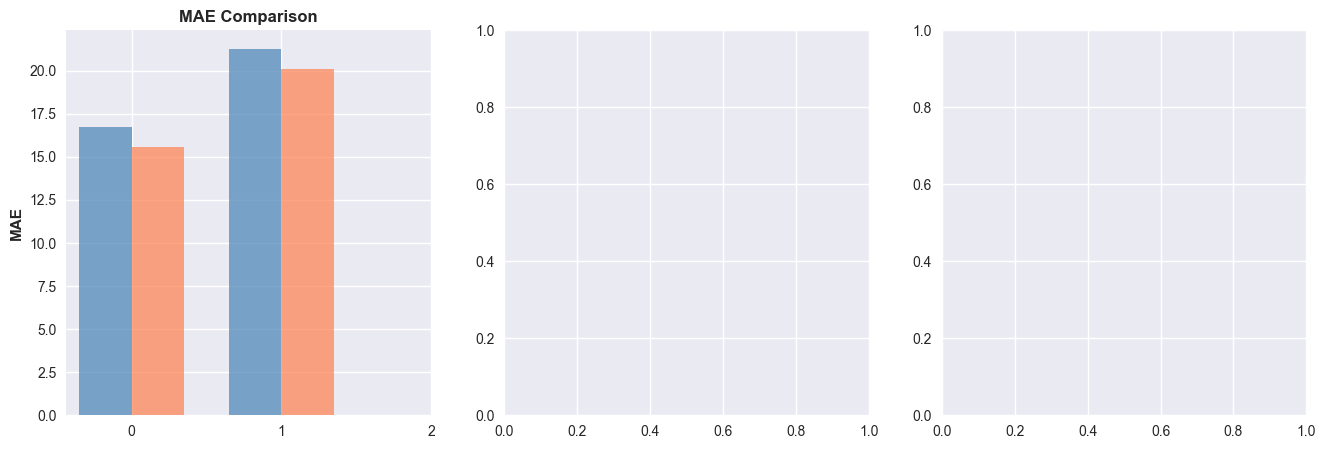

In [11]:
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

metrics = ['MAE', 'RMSE', 'R²']
original_lstm = [original_lstm_test_mae, original_lstm_test_rmse, original_lstm_test_r2]
reduced_lstm = [test_mae_lstm, test_rmse_lstm, test_r2_lstm]
original_rf = [original_rf_test_mae, original_rf_test_rmse, original_rf_test_r2]
reduced_rf = [test_mae_rf, test_rmse_rf, test_r2_rf]

x = np.arange(len(metrics))
width = 0.35

for i, (metric, orig_lstm, red_lstm, orig_rf, red_rf) in enumerate(zip(metrics, original_lstm, reduced_lstm, original_rf, reduced_rf)):
    axes[i].bar(x[0] - width/2, orig_lstm, width, label='Original (175)', color='steelblue', alpha=0.7)
    axes[i].bar(x[0] + width/2, red_lstm, width, label='Reduced (57)', color='coral', alpha=0.7)
    axes[i].bar(x[1] - width/2, orig_rf, width, color='steelblue', alpha=0.7)
    axes[i].bar(x[1] + width/2, red_rf, width, color='coral', alpha=0.7)
    
    axes[i].set_ylabel(metric, fontweight='bold')
    axes[i].set_title(f'{metric} Comparison', fontweight='bold')
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(['LSTM', 'Random Forest'])
    axes[i].legend()
    axes[i].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n✅ Comparison visualization complete!")
